In [1]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedGroupKFold
import timm 
from tqdm.auto import tqdm 
import wandb
from torch.optim.lr_scheduler import CosineAnnealingLR

In [2]:
wandb.login()

wandb: Currently logged in as: maikotrede (hms-hslu-aicomp-hs25) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
df = pd.read_csv('../data/processed_data_sum_votes_window.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()

Train shape: (17089, 12)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,spectrogram_id,min_offset,max_offset,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,568657,789577333,0.0,16.0,20654,Other,0.0,0.000000,0.25,0.000000,0.166667,0.583333
1,582999,1552638400,0.0,38.0,20230,LPD,0.0,0.857143,0.00,0.071429,0.000000,0.071429
2,642382,14960202,1008.0,1032.0,5955,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000
3,751790,618728447,908.0,908.0,38549,GPD,0.0,0.000000,1.00,0.000000,0.000000,0.000000
4,778705,52296320,0.0,0.0,40955,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000


In [4]:
df = pd.read_parquet('../data/train_spectrograms/353733.parquet')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()

Train shape: (320, 401)
Targets ['RP_18.95', 'RP_19.14', 'RP_19.34', 'RP_19.53', 'RP_19.73', 'RP_19.92']


,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,1,4.26,10.98,9.05,13.65,11.49,8.930000,18.840000,19.26,19.240000,...,0.31,0.17,0.28,0.19,0.24,0.27,0.29,0.16,0.22,0.19
1,3,2.65,3.97,12.18,13.26,14.21,13.230000,9.650000,8.11,11.280000,...,0.15,0.13,0.14,0.24,0.24,0.36,0.35,0.31,0.36,0.40
2,5,4.18,4.53,8.77,14.26,13.36,16.559999,19.219999,17.51,22.650000,...,0.29,0.21,0.16,0.25,0.28,0.28,0.34,0.48,0.44,0.48
3,7,2.41,3.21,4.92,8.07,5.97,12.420000,10.820000,14.96,21.809999,...,0.33,0.51,0.49,0.64,0.58,0.42,0.32,0.31,0.32,0.33
4,9,2.29,2.44,2.77,4.62,5.39,7.080000,9.840000,12.27,14.410000,...,0.44,0.38,0.48,0.63,0.45,0.45,0.49,0.33,0.31,0.34


In [5]:

def display_spectrogram(spectrogram_tensor, labels, targets):
    """
    Displays a spectrogram tensor with its corresponding labels.
    """
    img_np = spectrogram_tensor[0].numpy()
    
    plt.figure(figsize=(12, 5))
    plt.imshow(img_np, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Normalized Log Power')
    plt.xlabel('Time Steps')
    plt.ylabel('Frequency Bins')
    
    label_str = ", ".join([f"{name}: {val:.2f}" for name, val in zip(targets, labels)])
    plt.title(f"Spectrogram Sample\nLabels: {label_str}")
    
    plt.tight_layout()
    plt.show()

In [6]:


class KFoldCreator:
    """
    A class to create stratified group k-folds for cross-validation.
    """
    def __init__(self, n_splits, seed):
        self.n_splits = n_splits
        self.seed = seed

    def create_folds(self, df, stratify_col, group_col):
        """
        Divides the data into `n_splits` folds.
        """
        sgkf = StratifiedGroupKFold(n_splits=self.n_splits, shuffle=True, random_state=self.seed)

        folds_df = df.copy()
        folds_df["fold"] = -1
        folds_df.reset_index(drop=True, inplace=True)
        for fold, (_, val_idx) in enumerate(sgkf.split(folds_df, y=folds_df[stratify_col], groups=folds_df[group_col])):
            folds_df.loc[val_idx, "fold"] = fold

        return folds_df

class CFG:
    seed = 42
    n_splits = 5
    data_path = '../data/'
    
    model_name = 'tf_efficientnet_b0_ns'
    in_channels = 4  
    target_size = 6 
    
    batch_size = 32
    num_workers = 0
    epochs = 5
    lr = 1e-3
    
    # This is the base size of each channel, not the final reshaped size
    img_size = (128, 256)


def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        #torch.backends.cudnn.deterministic = True

set_seed(CFG.seed)



In [7]:
print("Preparing data and creating folds...")
df = pd.read_csv(CFG.data_path + 'processed_data_sum_votes_window.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape)
print('Targets', list(TARGETS))

fold_creator = KFoldCreator(n_splits=CFG.n_splits, seed=CFG.seed)
df = fold_creator.create_folds(df, stratify_col='expert_consensus', group_col='patient_id')

print("Folds created. Value counts per fold:")
print(df['fold'].value_counts())


Preparing data and creating folds...
Train shape: (17089, 12)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
Folds created. Value counts per fold:
fold
1    3938
2    3667
4    3417
0    3334
3    2733
Name: count, dtype: int64


In [8]:
class SpectrogramDataset(Dataset):
    def __init__(self, df, targets, data_path, img_size):
        self.df = df
        self.targets = targets
        self.data_path = data_path
        self.img_size = img_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
            row = self.df.iloc[idx]
            spectrogram_id = row['spectrogram_id']
            spec_path = os.path.join(self.data_path, 'train_spectrograms', f'{spectrogram_id}.parquet')
            spec_df = pd.read_parquet(spec_path)

            processed_channels = []
            
            #we treat each of the montage blocks as seperate channels
            for k in range(4):
                # Extract 100 rows for the current EEG channel and transpose
                # The +1 is to skip the 'time' column
                start_col = k * 100 + 1
                end_col = (k + 1) * 100 + 1
                img = spec_df.iloc[:, start_col:end_col].values.T # Shape: (100, time)

                # Log transform (to make the differences between values less extreme)
                img = np.clip(img, np.exp(-4), np.exp(8))
                img = np.log(img)

                # standardize per channel to focus on
                ep = 1e-6
                m = np.nanmean(img.flatten())
                s = np.nanstd(img.flatten())
                img = (img - m) / (s + ep)
                img = np.nan_to_num(img, nan=0.0)

                # Crop time axis to 256 and pad frequency axis to 128
                time_dim = img.shape[1]
                crop_start = (time_dim - 256) // 2
                img_cropped = img[:, crop_start:crop_start+256] # Shape: (100, 256)

                padded_img = np.zeros((128, 256), dtype=np.float32)
                padded_img[14:-14, :] = img_cropped # Center the 100 rows in a 128-row image
                
                processed_channels.append(padded_img)

            # Stack the 4 channels to create a [4, 128, 256] image
            spectrogram = np.stack(processed_channels, axis=0)
            
            spectrogram_tensor = torch.tensor(spectrogram, dtype=torch.float32)
            
            labels = torch.tensor(row[self.targets], dtype=torch.float32)
            
            return spectrogram_tensor, labels




In [9]:
class HMSModel(nn.Module):
    def __init__(self, model_name, pretrained=True, in_channels=4, num_classes=6):
        super().__init__()
        self.model = timm.create_model(
            model_name,
            pretrained=pretrained,
            in_chans=3, 
            num_classes=num_classes
        )

    def forward(self, x):
        # Input x has shape [batch_size, 4, 128, 256]
        # Split the 4 channels into a list of 4 tensors
        # Each tensor has shape [batch_size, 1, 128, 256]
        channels = torch.split(x, 1, dim=1)
        
        # Concatenate along the height dimension
        # This creates a tensor of shape [batch_size, 1, 512, 256]
        x_reshaped = torch.cat(channels, dim=2)
        
        # Repeat the single channel 3 times to create a 3-channel image
        # Final shape is [batch_size, 3, 512, 256]
        x_3_channel = x_reshaped.repeat(1, 3, 1, 1)
        
        return self.model(x_3_channel)



In [10]:
def get_dataloaders(df, fold_id):
    train_df = df[df['fold'] != fold_id].reset_index(drop=True)
    valid_df = df[df['fold'] == fold_id].reset_index(drop=True)

    train_dataset = SpectrogramDataset(train_df, TARGETS, CFG.data_path, CFG.img_size)
    valid_dataset = SpectrogramDataset(valid_df, TARGETS, CFG.data_path, CFG.img_size)

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False
    )
    
    return train_loader, valid_loader





Displaying a few sample spectrograms before training...


/tmp/ipykernel_147227/2685466871.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.tensor(row[self.targets], dtype=torch.float32)


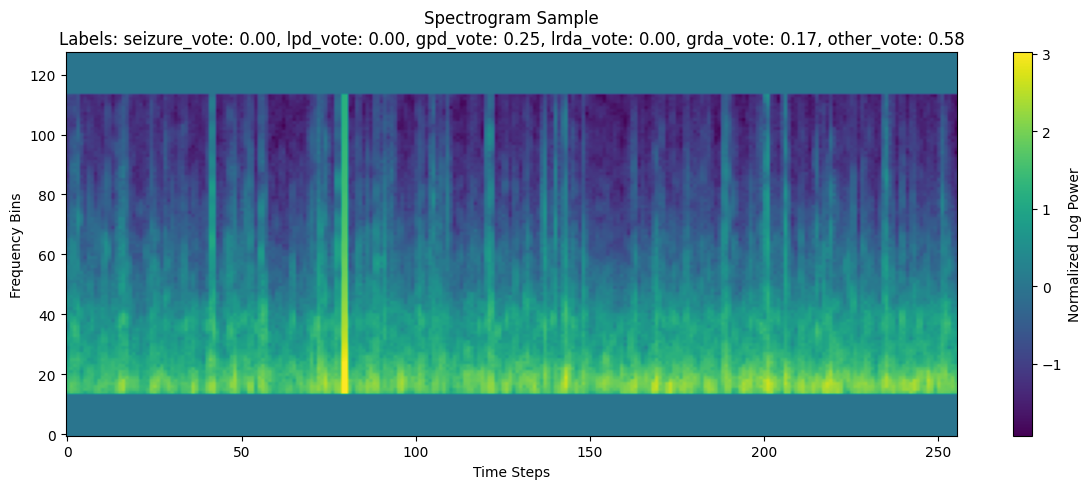

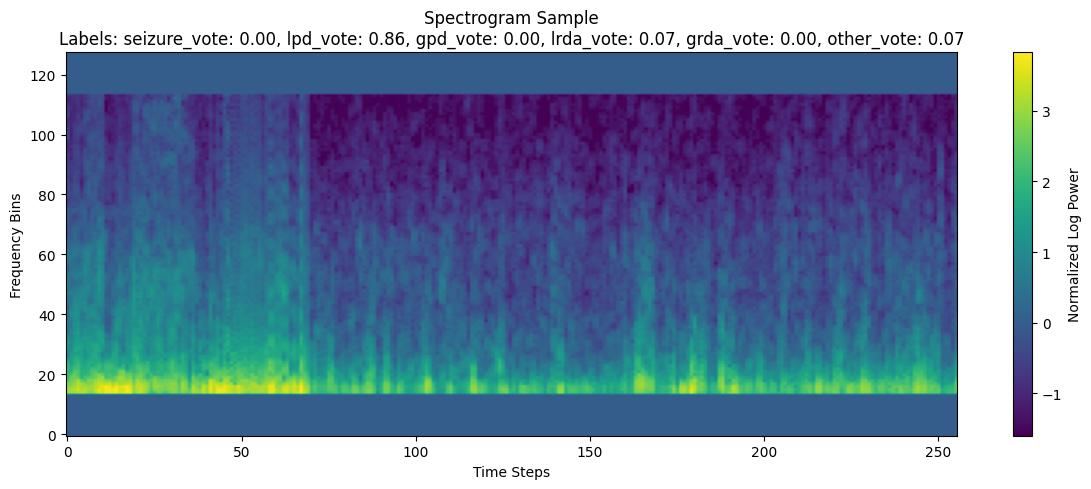

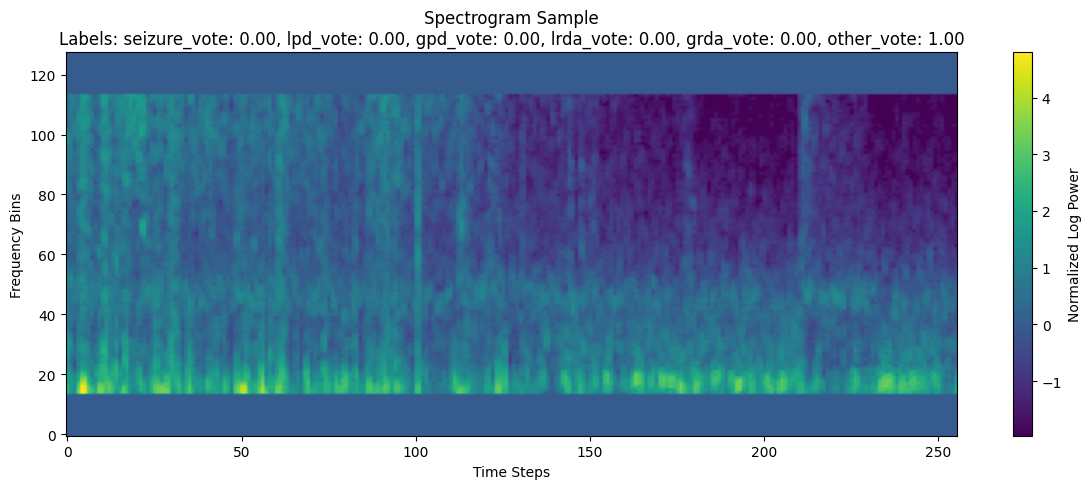

Using device: cuda

========== FOLD 0 ==========


/home/maiko/miniconda3/envs/aicomp/lib/python3.13/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


  --- Epoch 1/5 ---


Training:   0%|          | 0/429 [00:00<?, ?it/s]

/tmp/ipykernel_147227/2685466871.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.tensor(row[self.targets], dtype=torch.float32)


Validation:   0%|          | 0/105 [00:00<?, ?it/s]

   Epoch 1: Train Loss = 0.8103, Valid Loss = 0.8246, LR = 0.001000
  New best model saved with validation loss: 0.8246
  --- Epoch 2/5 ---


Training:   0%|          | 0/429 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

   Epoch 2: Train Loss = 0.5642, Valid Loss = 0.7438, LR = 0.000905
  New best model saved with validation loss: 0.7438
  --- Epoch 3/5 ---


Training:   0%|          | 0/429 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

   Epoch 3: Train Loss = 0.4273, Valid Loss = 0.8012, LR = 0.000655
  --- Epoch 4/5 ---


Training:   0%|          | 0/429 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

   Epoch 4: Train Loss = 0.3114, Valid Loss = 0.7459, LR = 0.000345
  --- Epoch 5/5 ---


Training:   0%|          | 0/429 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

   Epoch 5: Train Loss = 0.2261, Valid Loss = 0.7724, LR = 0.000095

Logged artifact for fold 0 with best validation loss: 0.7438


epoch,▁▃▅▆█
train/epoch_loss,█▅▃▂▁
train/epoch_lr,█▇▅▃▁
train/loss,▇▇▇▅▆█▆▅█▅▄▄▃▄▅▃▄▅▅▄▄▂▄▃▃▃▂▂▁▃▂▁▂▁▁▁▁▂▂▂
val/kl_div,█▁▆▁▃
val/loss,█▁▆▁▃
best_val_kl_div,0.74379
epoch,5
train/epoch_loss,0.22612
train/epoch_lr,0.0001
train/loss,0.24539



========== FOLD 1 ==========


/home/maiko/miniconda3/envs/aicomp/lib/python3.13/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


  --- Epoch 1/5 ---


Training:   0%|          | 0/410 [00:00<?, ?it/s]

/tmp/ipykernel_147227/2685466871.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.tensor(row[self.targets], dtype=torch.float32)


Validation:   0%|          | 0/124 [00:00<?, ?it/s]

   Epoch 1: Train Loss = 0.8130, Valid Loss = 0.7573, LR = 0.001000
  New best model saved with validation loss: 0.7573
  --- Epoch 2/5 ---


Training:   0%|          | 0/410 [00:00<?, ?it/s]

Validation:   0%|          | 0/124 [00:00<?, ?it/s]

   Epoch 2: Train Loss = 0.5626, Valid Loss = 0.8345, LR = 0.000905
  --- Epoch 3/5 ---


Training:   0%|          | 0/410 [00:00<?, ?it/s]

Validation:   0%|          | 0/124 [00:00<?, ?it/s]

   Epoch 3: Train Loss = 0.4404, Valid Loss = 0.8214, LR = 0.000655
  --- Epoch 4/5 ---


Training:   0%|          | 0/410 [00:00<?, ?it/s]

Validation:   0%|          | 0/124 [00:00<?, ?it/s]

   Epoch 4: Train Loss = 0.3129, Valid Loss = 0.7872, LR = 0.000345
  --- Epoch 5/5 ---


Training:   0%|          | 0/410 [00:00<?, ?it/s]

Validation:   0%|          | 0/124 [00:00<?, ?it/s]

   Epoch 5: Train Loss = 0.2267, Valid Loss = 0.7968, LR = 0.000095

Logged artifact for fold 1 with best validation loss: 0.7573


epoch,▁▃▅▆█
train/epoch_loss,█▅▄▂▁
train/epoch_lr,█▇▅▃▁
train/loss,█▆▄▄▄▄▅▃▃▄▃▃▄▃▄▄▂▂▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂
val/kl_div,▁█▇▄▅
val/loss,▁█▇▄▅
best_val_kl_div,0.75732
epoch,5
train/epoch_loss,0.22674
train/epoch_lr,0.0001
train/loss,0.15694



========== FOLD 2 ==========


/home/maiko/miniconda3/envs/aicomp/lib/python3.13/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


  --- Epoch 1/5 ---


Training:   0%|          | 0/419 [00:00<?, ?it/s]

/tmp/ipykernel_147227/2685466871.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.tensor(row[self.targets], dtype=torch.float32)


Validation:   0%|          | 0/115 [00:00<?, ?it/s]

   Epoch 1: Train Loss = 0.8284, Valid Loss = 0.9034, LR = 0.001000
  New best model saved with validation loss: 0.9034
  --- Epoch 2/5 ---


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Validation:   0%|          | 0/115 [00:00<?, ?it/s]

   Epoch 2: Train Loss = 0.5677, Valid Loss = 0.8076, LR = 0.000905
  New best model saved with validation loss: 0.8076
  --- Epoch 3/5 ---


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Validation:   0%|          | 0/115 [00:00<?, ?it/s]

   Epoch 3: Train Loss = 0.4420, Valid Loss = 0.8838, LR = 0.000655
  --- Epoch 4/5 ---


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Validation:   0%|          | 0/115 [00:00<?, ?it/s]

   Epoch 4: Train Loss = 0.3266, Valid Loss = 0.8002, LR = 0.000345
  New best model saved with validation loss: 0.8002
  --- Epoch 5/5 ---


Training:   0%|          | 0/419 [00:00<?, ?it/s]

Validation:   0%|          | 0/115 [00:00<?, ?it/s]

   Epoch 5: Train Loss = 0.2323, Valid Loss = 0.8200, LR = 0.000095

Logged artifact for fold 2 with best validation loss: 0.8002


epoch,▁▃▅▆█
train/epoch_loss,█▅▃▂▁
train/epoch_lr,█▇▅▃▁
train/loss,▅█▇▆▆▅▄█▄▄▄▄▄▄▅▅▃▂▃▄▃▄▂▂▂▂▂▃▂▂▃▂▂▁▁▂▂▂▃▂
val/kl_div,█▁▇▁▂
val/loss,█▁▇▁▂
best_val_kl_div,0.80021
epoch,5
train/epoch_loss,0.23232
train/epoch_lr,0.0001
train/loss,0.27833



========== FOLD 3 ==========


/home/maiko/miniconda3/envs/aicomp/lib/python3.13/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


  --- Epoch 1/5 ---


Training:   0%|          | 0/448 [00:00<?, ?it/s]

/tmp/ipykernel_147227/2685466871.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.tensor(row[self.targets], dtype=torch.float32)


Validation:   0%|          | 0/86 [00:00<?, ?it/s]

   Epoch 1: Train Loss = 0.8137, Valid Loss = 0.7762, LR = 0.001000
  New best model saved with validation loss: 0.7762
  --- Epoch 2/5 ---


Training:   0%|          | 0/448 [00:00<?, ?it/s]

Validation:   0%|          | 0/86 [00:00<?, ?it/s]

   Epoch 2: Train Loss = 0.5659, Valid Loss = 0.7771, LR = 0.000905
  --- Epoch 3/5 ---


Training:   0%|          | 0/448 [00:00<?, ?it/s]

Validation:   0%|          | 0/86 [00:00<?, ?it/s]

   Epoch 3: Train Loss = 0.4429, Valid Loss = 0.7004, LR = 0.000655
  New best model saved with validation loss: 0.7004
  --- Epoch 4/5 ---


Training:   0%|          | 0/448 [00:00<?, ?it/s]

Validation:   0%|          | 0/86 [00:00<?, ?it/s]

   Epoch 4: Train Loss = 0.3204, Valid Loss = 0.7257, LR = 0.000345
  --- Epoch 5/5 ---


Training:   0%|          | 0/448 [00:00<?, ?it/s]

Validation:   0%|          | 0/86 [00:00<?, ?it/s]

   Epoch 5: Train Loss = 0.2360, Valid Loss = 0.7214, LR = 0.000095

Logged artifact for fold 3 with best validation loss: 0.7004


epoch,▁▃▅▆█
train/epoch_loss,█▅▄▂▁
train/epoch_lr,█▇▅▃▁
train/loss,█▆▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁
val/kl_div,██▁▃▃
val/loss,██▁▃▃
best_val_kl_div,0.70043
epoch,5
train/epoch_loss,0.23601
train/epoch_lr,0.0001
train/loss,0.15309



========== FOLD 4 ==========


/home/maiko/miniconda3/envs/aicomp/lib/python3.13/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


  --- Epoch 1/5 ---


Training:   0%|          | 0/427 [00:00<?, ?it/s]

/tmp/ipykernel_147227/2685466871.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.tensor(row[self.targets], dtype=torch.float32)


Validation:   0%|          | 0/107 [00:00<?, ?it/s]

   Epoch 1: Train Loss = 0.8034, Valid Loss = 0.8597, LR = 0.001000
  New best model saved with validation loss: 0.8597
  --- Epoch 2/5 ---


Training:   0%|          | 0/427 [00:00<?, ?it/s]

Validation:   0%|          | 0/107 [00:00<?, ?it/s]

   Epoch 2: Train Loss = 0.5572, Valid Loss = 0.8394, LR = 0.000905
  New best model saved with validation loss: 0.8394
  --- Epoch 3/5 ---


Training:   0%|          | 0/427 [00:00<?, ?it/s]

Validation:   0%|          | 0/107 [00:00<?, ?it/s]

   Epoch 3: Train Loss = 0.4377, Valid Loss = 0.8239, LR = 0.000655
  New best model saved with validation loss: 0.8239
  --- Epoch 4/5 ---


Training:   0%|          | 0/427 [00:00<?, ?it/s]

Validation:   0%|          | 0/107 [00:00<?, ?it/s]

   Epoch 4: Train Loss = 0.3109, Valid Loss = 0.8518, LR = 0.000345
  --- Epoch 5/5 ---


Training:   0%|          | 0/427 [00:00<?, ?it/s]

Validation:   0%|          | 0/107 [00:00<?, ?it/s]

   Epoch 5: Train Loss = 0.2234, Valid Loss = 0.8533, LR = 0.000095

Logged artifact for fold 4 with best validation loss: 0.8239


epoch,▁▃▅▆█
train/epoch_loss,█▅▄▂▁
train/epoch_lr,█▇▅▃▁
train/loss,▇▆▅█▅▃▄▄▃▄▃▆▃▃▄▄▄▃▃▂▃▄▅▃▃▂▁▂▂▂▃▂▂▁▁▂▁▁▂▂
val/kl_div,█▄▁▆▇
val/loss,█▄▁▆▇
best_val_kl_div,0.82395
epoch,5
train/epoch_loss,0.22344
train/epoch_lr,0.0001
train/loss,0.15995


In [11]:
def run_training():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    for fold in range(CFG.n_splits):
        print(f"\n========== FOLD {fold} ==========")

        config = {
            # Model
            "architecture": CFG.model_name, "pretrained": True,
            # Data
            "fold": fold, "features": "spectrograms", "window_selection": "sum_and_normalize",
            # Training
            "optimizer": "AdamW", "learning_rate": CFG.lr, "batch_size": CFG.batch_size,
            "epochs": CFG.epochs, "seed": CFG.seed, "Scheduler": "CosineAnnealingLR" 
        }

        wandb.init(
            project="hms-aicomp",
            name=f"effnetb0-spec-fold{fold}", 
            tags=['baseline', f'fold{fold}'],
            config=config
        )

        model = HMSModel(CFG.model_name, pretrained=True, num_classes=CFG.target_size)
        model.to(device)

        optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG.epochs)
        loss_fn = nn.KLDivLoss(reduction='batchmean')
        train_loader, valid_loader = get_dataloaders(df, fold)

        best_val_loss = float('inf')
        best_model_path = None

        for epoch in range(CFG.epochs):
            print(f"  --- Epoch {epoch+1}/{CFG.epochs} ---")

            model.train()
            train_loss = 0
            for images, labels in tqdm(train_loader, desc="Training"):
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                log_probs = F.log_softmax(outputs, dim=1)
                loss = loss_fn(log_probs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * images.size(0)

                current_lr = optimizer.param_groups[0]['lr']
                wandb.log({"train/loss": loss.item()})

            train_loss /= len(train_loader.dataset)

            model.eval()
            valid_loss = 0
            with torch.no_grad():
                for images, labels in tqdm(valid_loader, desc="Validation"):
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    log_probs = F.log_softmax(outputs, dim=1)
                    loss = loss_fn(log_probs, labels)
                    valid_loss += loss.item() * images.size(0)

            valid_loss /= len(valid_loader.dataset)
            
            epoch_lr = optimizer.param_groups[0]['lr']
            print(f"   Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Valid Loss = {valid_loss:.4f}, LR = {epoch_lr:.6f}")

            wandb.log({
                "epoch": epoch + 1,
                "train/epoch_loss": train_loss,
                "val/loss": valid_loss,
                "val/kl_div": valid_loss,
                "train/epoch_lr": epoch_lr
            })

            if valid_loss < best_val_loss:
                best_val_loss = valid_loss
                best_model_path = f'best_model_fold{fold}.pth'
                torch.save(model.state_dict(), best_model_path)
                print(f"  New best model saved with validation loss: {best_val_loss:.4f}")
            scheduler.step()

        wandb.summary['best_val_kl_div'] = best_val_loss

        if best_model_path:
            artifact = wandb.Artifact(f'model-fold{fold}', type='model')
            artifact.add_file(best_model_path)
            wandb.log_artifact(artifact)
            print(f"\nLogged artifact for fold {fold} with best validation loss: {best_val_loss:.4f}")
        else:
            print("\nNo best model was saved during training for this fold.")

        wandb.finish()



if __name__ == '__main__':

    print("\nDisplaying a few sample spectrograms before training...")
    temp_dataset = SpectrogramDataset(df, TARGETS, CFG.data_path, CFG.img_size)
    for i in range(3): 
        spectrogram, labels = temp_dataset[i]
        display_spectrogram(spectrogram, labels.numpy(), TARGETS) 

    run_training()